In [54]:
from lib.ekyn import *
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch import nn
from torch.nn.functional import relu
from lib.models import *
from lib.deep_learning_utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,f1_score

ekyn_ids = get_ekyn_ids()

n_samples = len(ekyn_ids) * 17280
n_seconds = n_samples * 10
n_hours = n_seconds / 3600
print(f'{n_hours} hours')

768.0 hours


In [77]:
model = ResNetv2(block=ResBlockv2,widthi=[64,128,256],depthi=[2,2,2],n_output_neurons=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4)

In [78]:
trainlossi = []
testlossi = []

In [79]:
trainloader = get_ratloader(ekyn_ids[:1])
testloader = get_ratloader(ekyn_ids[1:2])

model.to('mps')
from tqdm import tqdm
for i in tqdm(range(1000)):
    model.train()
    loss_total = 0
    for Xi,yi in trainloader:
        Xi,yi = Xi.to('mps'),yi.to('mps')
        logits = model(Xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    trainlossi.append(loss_total/len(trainloader))

    model.eval()
    from tqdm import tqdm
    with torch.no_grad():
        loss_total = 0
        for Xi,yi in testloader:
            Xi,yi = Xi.to('mps'),yi.to('mps')
            logits = model(Xi)
            loss = criterion(logits,yi)
            loss_total += loss.item()
        testlossi.append(loss_total/len(testloader))
    
    plt.figure()
    plt.plot(trainlossi)
    plt.plot(testlossi)
    plt.savefig('loss.jpg')
    plt.close()

  9%|▉         | 90/1000 [10:17<1:44:00,  6.86s/it]


KeyboardInterrupt: 

0.4055209931205301
0.3716827543342815


Text(0.5, 1.0, 'testf1 : 0.612')

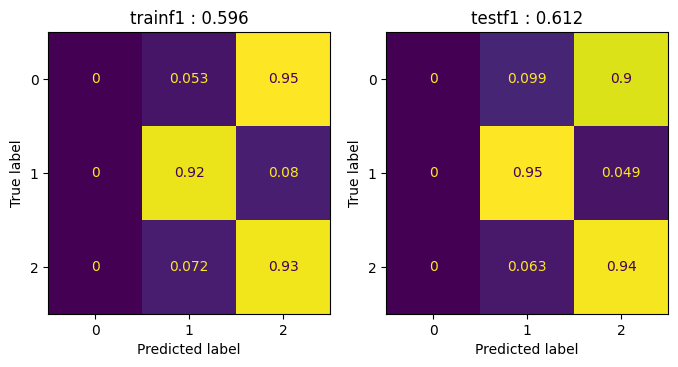

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
loss,y_true,y_pred = evaluate(dataloader=trainloader,model=model,criterion=criterion,device='mps')
print(loss)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',ax=axes[0],colorbar=False)
axes[0].set_title(f'trainf1 : {f1_score(y_true,y_pred,average="macro"):.3f}')
loss,y_true,y_pred = evaluate(dataloader=testloader,model=model,criterion=criterion,device='mps')
print(loss)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',ax=axes[1],colorbar=False)
axes[1].set_title(f'testf1 : {f1_score(y_true,y_pred,average="macro"):.3f}')

In [59]:


df = pd.DataFrame()

plt.figure(figsize=(14,8))
for id in ekyn_ids[:10]:
    print(id)
    X,y = load_ekyn_pt_robust(id=id,condition='Vehicle')
    std,mean = torch.std_mean(X[torch.where(y.argmax(axis=1) == 1)[0]]
,dim=1)
    sns.ecdfplot(std,linewidth=2,label=id,color='blue')

# df_long = df.melt()
# df_long[['id','condition']] = df_long.variable.str.split('_',expand=True)
# sns.ecdfplot(df_long[df_long.condition == 'Vehicle'],x='value',hue='id',linestyle='-')
# sns.ecdfplot(df_long[df_long.condition == 'PF'],x='value',hue='id',linestyle='--')
# std,mean = torch.std_mean(eeg,dim=1)

plt.legend()
plt.xlim([0,2])

A1-0


TypeError: load_ekyn_pt_robust() missing 1 required positional argument: 'downsampled'

<Figure size 1400x800 with 0 Axes>

In [ ]:
X.shape

In [ ]:
df = pd.DataFrame()

plt.figure(figsize=(14,8))
for id in idx:
    for condition in ['Vehicle','PF']:
        X,y = load_ekyn_pt(idx=id,condition=condition)
        std,mean = torch.std_mean(X,dim=1)
        df[f'{id}_{condition}'] = std
df_long = df.melt()
df_long[['id','condition']] = df_long.variable.str.split('_',expand=True)
sns.ecdfplot(df_long[df_long.condition == 'Vehicle'],x='value',hue='id',linestyle='-')
sns.ecdfplot(df_long[df_long.condition == 'PF'],x='value',hue='id',linestyle='--')
std,mean = torch.std_mean(eeg,dim=1)
sns.ecdfplot(std,linewidth=2)


plt.xlim([0,.0002])

In [ ]:
idx = get_ekyn_ids()
# train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
train_idx = get_ekyn_ids()
test_idx = [train_idx[12]]
train_idx.remove(test_idx[0])
print(train_idx,test_idx)
print(len(train_idx),len(test_idx))

In [ ]:
df = pd.DataFrame()

for id in idx:
    for condition in ['Vehicle','PF']:
        X,y = load_ekyn_pt(idx=id,condition=condition)
        df[f'{id}_{condition}'] = torch.bincount(y.argmax(axis=1))/len(y)

In [ ]:
df = df.T

In [ ]:
plt.figure(figsize=(7.2,7.2),dpi=200)
sns.boxplot(data=df)

In [ ]:
s = df.describe()[1]
w = df.describe()[2]
iqr_s = s['75%'] - s['25%']
iqr_w = w['75%'] - w['25%']
lower_outlier_s = s['25%'] - (1.5*iqr_s)
upper_outlier_w = w['75%'] + (1.5*iqr_w)
lower_outlier_s

In [ ]:
df[(df[1] < lower_outlier_s) | (df[2] > upper_outlier_w)]

In [ ]:
from mne.io import read_raw_edf

eeg = torch.from_numpy(read_raw_edf(f'./24-AGING-2.edf').get_data(picks=['EEG 1'])[0]).float().reshape(-1,5000)

In [ ]:
df = pd.DataFrame()

plt.figure(figsize=(14,8))
for id in idx:
    for condition in ['Vehicle','PF']:
        X,y = load_ekyn_pt(idx=id,condition=condition)
        std,mean = torch.std_mean(X,dim=1)
        df[f'{id}_{condition}'] = std
df_long = df.melt()
df_long[['id','condition']] = df_long.variable.str.split('_',expand=True)
sns.ecdfplot(df_long[df_long.condition == 'Vehicle'],x='value',hue='id',linestyle='-')
sns.ecdfplot(df_long[df_long.condition == 'PF'],x='value',hue='id',linestyle='--')
std,mean = torch.std_mean(eeg,dim=1)
sns.ecdfplot(std,linewidth=2)


plt.xlim([0,.0002])